**ASSIGNMENT 1 - EMPIRICAL STUDY OF KNAPSACK PROBLEM**

**1. Group Description**

Group Number: \\
Member Names: \\
Member Student Numbers: \\

**2. Knapsack Problem**

Give a description of the problem tackled.

**3. Dataset**

Give a description of the dataset used with references.  

**Import important libraries**

In [6]:
import pandas as pd
import itertools
import numpy as np

**Read Dataset**

As outlined in the project description, it should be possible for the correctors to execute your notebook without requiring any downloads.

To facilitate access to the dataset without the need for downloads, you can upload it to a public GitHub repository and provide a link to the raw version of the dataset.

The link to the raw version is as follows:
*https://raw.githubusercontent.com/GITHUB_USERNAME/REPOSITORY_NAME/main/DATASETNAME.csv*

For example:

https://raw.githubusercontent.com/baharin/KnapsackProblem/main/knapsack_5_items.csv

Now provide the link to YOUR dataset and read the dataset using pandas:

In [7]:
url = "https://raw.githubusercontent.com/uOttawa-Collabs/CSI4106-Fall-2023/master/Assignment%201/knapsack_5_items.csv"

dataset = pd.read_csv(url)

Let's see what are the columns of the dataset? :

In [8]:
dataset.columns

Index(['Weights', 'Prices', 'Capacity', 'Best picks', 'Best price'], dtype='object')

As we expected, we have columns for weights, costs, capacity, best picks and best price for all the instances.

Now let's see the first 10 entries (rows):

In [9]:
dataset.head(10)

,Weights,Prices,Capacity,Best picks,Best price
0,[46 40 42 38 10],[12 19 19 15 8],40,[0. 1. 0. 0. 0.],19.0
1,[11 31 4 6 7],[ 2 8 18 16 3],64,[1. 1. 1. 1. 1.],47.0
2,[32 49 27 37 24],[19 16 16 4 1],87,[1. 0. 1. 0. 1.],36.0
3,[20 35 22 23 16],[19 17 19 9 1],21,[1. 0. 0. 0. 0.],19.0
4,[ 7 12 19 13 20],[10 11 18 15 5],50,[0. 1. 1. 1. 0.],44.0
5,[27 10 25 25 7],[13 19 7 16 3],66,[1. 1. 0. 1. 0.],48.0
6,[21 2 33 45 26],[ 1 14 10 6 13],80,[0. 1. 1. 0. 1.],37.0
7,[37 27 39 14 25],[18 7 15 4 13],35,[0. 0. 0. 0. 1.],13.0
8,[ 1 48 4 23 39],[ 9 4 10 16 12],51,[1. 0. 1. 1. 0.],35.0
9,[ 4 3 22 9 32],[14 6 3 17 8],53,[1. 1. 0. 1. 1.],45.0


**Preprocessing Step**

Typically, the initial step in any project that involves reading and handling data is data preprocessing and cleansing.

In our dataset, we expect the entries in the "Weights," "Prices," and "Best Picks" columns to be in the form of arrays of floats or integers, like this: [45, 40, 42, 38, 10]

However, when you read each entry using pandas, they will be in a form of a string: "[45 40 42 38 10]"

So we need to convert these strings into "arrays of floats or integers." You can utilize the function provided below for this purpose:


In [10]:
def string_to_list(string):

    string_list = string.strip('[]').split()

    float_list = [float(element) for element in string_list]

    return float_list

Furthermore, it's possible that certain rows in the dataset contain empty values in specific columns. We also aim to eliminate these rows as they do not provide any useful information. We use dropna() function to do so:

In [11]:
#Ignore the warning messages.

dataset = dataset.dropna()

dataset.Weights = dataset.Weights.apply(lambda x : string_to_list(x))
dataset.Prices = dataset.Prices.apply(lambda x : string_to_list(x))
dataset['Best picks'] = dataset['Best picks'].apply(lambda x : string_to_list(x))

Now it's time to implement the search algorithms. For each algorithm, a template is provided to you. You can modify this template if you want. But first you should try to go look at all the parameters used, as they are all important. You can also define any number of auxiliary functions you want.


**4. Generate and Test**

Give a description... Also, make sure that you put comments using your own words in the code to show that you understand the code that you are submitting.

In [12]:
def int_to_binary_bits(n, min_length):
    assert n >= 0
    bits = list(int(bit) for bit in bin(n)[2:])
    padding = []
    if len(bits) < min_length:
        padding = [0] * (min_length - len(bits))
    return padding + bits
    

def gen_and_test(data):
    weights = data["Weights"]
    prices = data["Prices"]
    capacity = data["Capacity"]

    assert len(weights) == len(prices)
    item_count = len(weights)

    best_solution_price = 0
    best_solution = None

    for i in range(0, 2 ** item_count):
        current_solution = int_to_binary_bits(i, item_count)
        current_solution_weight = sum(weight * in_bag for weight, in_bag in zip(weights, current_solution))
        current_solution_price = sum(price * in_bag for price, in_bag in zip(prices, current_solution))
        if current_solution_weight <= capacity and current_solution_price > best_solution_price:
            best_solution_price = current_solution_price
            best_solution = current_solution
    
    return best_solution_price, best_solution


In [13]:
solutions = []
for _, row in dataset.iterrows():
    target = row['Best price']
    solution, indexes = gen_and_test(row)
    solutions.append(1 if target == solution else 0)


In [14]:
# Accuracy
print('Accuracy of best prices found is', np.mean(solutions))

Accuracy of best prices found is 1.0


**Your Analysis:**

------------------------------------------------------------------------------------------------

**5. Greedy Search**

Give a description... Also, make sure that you put comments using your own words in the code to show that you understand the code that you are submitting.

In [13]:
def interest(item):
    _, price, weight, ratio = item
    #return ratio
    return price


def greedy(data):
    weights = data["Weights"]
    prices = data["Prices"]
    capacity = data["Capacity"]

    assert len(weights) == len(prices)
    item_count = len(weights)

    items = list((index, price, weight, price / weight) for index, (price, weight) in enumerate(zip(prices, weights)))
    items.sort(key=interest, reverse=True)

    best_solution = [0] * item_count
    current_weight = 0
    for index, _, weight, _ in items:
        if weight <= capacity - current_weight:
            best_solution[index] = 1
            current_weight += weight

    best_solution_price = sum(price * in_bag for price, in_bag in zip(prices, best_solution))
    
    return best_solution_price, best_solution


In [14]:
solutions_greedy = []
for _, row in dataset.iterrows():
    target = row['Best price']
    solution, indexes = greedy(row)
    solutions_greedy.append(1 if target == solution else 0)


In [15]:
print("Greedy Accuracy is", np.mean(solutions_greedy))

Greedy Accuracy is 0.9066707156594797


**Your Analysis:**

------------------------------------------------------------------------------------------------

**6. Simulated Annealing**

Give a description... Also, make sure that you put comments using your own words in the code to show that you understand the code that you are submitting.


To implement the simulated annealing algorithm, firstly I generated the initial soluiton by randomly picks. For each item, a random number will be generated: if the number is larger than 0.5, the current item will be added into the initial solution, otherwise it won't be added.

Then the algorithm will reapeat N times as cooling the temperature. For each time, a new valid solution will be generated. There are 3 ways to generate a new solution: take an item from the current solution, add an new item into the current solution, and take an item and add an another item into the current solution.

Next the acceptance will check if the new solution is acceptable. If the total price of the new solution is larger than the local maximum solution's, the new solution will replace the local maximum solution. If not, it is possible to be accepted based on the probability. Otherwise, the local maximum will keep the old solution. The lower tempeatrue means the lower probability to make changes.

At the end of an iteration, the temperature will be decreased based on the cooling rate.

In [91]:
import random
import math


def simulated_annealing(data, N, initial_temperature, cooling_rate):
    '''
    Implement the simulated annealing algorithm.
    '''
    #Initialize variables
    weights = data["Weights"]
    prices = data["Prices"]
    capacity = data["Capacity"]
    length = len(weights)
    temperature = initial_temperature

    #Randomly generating a valid solution
    initial_solution = get_initial_solution(weights, capacity, length)

    best_solution = initial_solution
    best_solution_price = get_total_value(prices, initial_solution)
    local_solution = initial_solution
    local_solution_price = best_solution_price

    #Return the solution if the result is empty bag
    if is_no_solution(weights, capacity):
        return 0, []
    
    #Return the solution if the bag can hold all items
    if is_one_solution(weights, capacity):
        pick_all = [1]*length
        return get_total_value(prices, pick_all), pick_all
    
    #Repeat N times according to the page 22 sudo code of lecture 3
    for i in range(N):
        #Generating a new valid solution based on the local maximum solution
        new_solution = get_new_solution(local_solution, weights, capacity)

        #Checking if the new solution is acceptable
        if acceptance(prices, new_solution, local_solution_price, cooling_rate, temperature):
            local_solution = new_solution
            local_solution_price = get_total_value(prices, local_solution)

            #Checking if the new solution has reached the global maximum
            if local_solution_price > best_solution_price:
                #Recording if it has reached
                best_solution = local_solution.copy()
                best_solution_price = local_solution_price
        
        #cooling temperatrue
        temperature = temperature * cooling_rate
        
    return best_solution_price, best_solution


def acceptance(prices: list[int], solution: list[int], local_solution_price: int, cooling_rate: float, temperature: float) -> bool:
    '''
    Check if the new solution is acceptable
    '''
    new_price = get_total_value(prices, solution)
    variation = new_price - local_solution_price

    #If the current solution is better than the local maximum solution
    if variation > 0:
        return True
    
    #Accept the current solution based on the probability
    #lower temperture means lower probability to make changes
    return cooling_rate < math.exp(variation/temperature)



def get_new_solution(tmp_solution: list[int], weights: list[int], capacity: int) -> list[int]:
    '''
    Generating a new solution which total weights is less than its capacity based on the current solution
    '''
    new_solution = []
    selected = []
    unselected = []
    for i in range(len(tmp_solution)):
        if tmp_solution[i] == 1:
            selected.append(i)
        else:
            unselected.append(i)
    
    #Put an item if the bag is empty
    if len(selected) == 0:
        return put(unselected, tmp_solution)
    
    while True:
        random_num = random.random()

        #Take an item from the bag
        if random_num < 0.333:
            new_solution = take(selected, tmp_solution)
        
        #Put an item into the bag
        elif random_num < 0.666:
            new_solution = put(unselected, tmp_solution)
        
        #Take an item and put an another item
        else:
            new_solution = take(selected, tmp_solution)
            new_solution = put(unselected, new_solution)
        
        #Return the result if the new soluiton is not over capacity
        if get_total_value(weights, new_solution) < capacity:
            break
    return new_solution


def get_initial_solution(weights: list[int], capacity: int, length: int) -> list[int]:
    '''
    Randomly generating a valid solution
    '''
    new_solution = [0]*length
    for i in range(length):
        if (random.random() > 0.5):
            new_solution[i] = 1
    
    #return if the solution is valid
    if get_total_value(weights, new_solution) < capacity:
        return new_solution
    
    #Else generating another solution
    return get_initial_solution(weights, capacity, length)


def get_total_value(data: list[int], solution: list[int]) -> int:
    '''
    Calculate the total weight / price of a solution
    '''
    result = 0
    for i in range(len(solution)):
        if solution[i]:
            result += data[i]
    return result


def put(unselected_list: list[int], tmp_solution: list[int]) -> list[int]:
    '''
    Randomly put an unselected item into the bag
    '''
    new_solution = tmp_solution.copy()
    if len(unselected_list) == 1:
        #If there is only one item can be chose
        random1 = 0
    else:
        random1 = math.floor(math.fmod(random.random() * 100, len(unselected_list)))
    
    new_solution[unselected_list[random1]] = 1

    return new_solution


def take(selected_list: list[int], tmp_solution: list[int]) -> list[int]:
    '''
    Randomly take an selected item from the bag
    '''
    new_solution = tmp_solution.copy()
    if len(selected_list) == 1:
        #If there is only one item can be chose
        random1 = 0
    else:
        random1 = math.floor(math.fmod(random.random() * 100, len(selected_list)))

    new_solution[selected_list[random1]] = 0

    return new_solution

def is_no_solution(weights: list[int], capacity: int) -> bool:
    '''
    Return True if the bag cannot put any item from the list, otherwise return False
    '''
    for i in weights:
        if i < capacity:
            return False
    return True

def is_one_solution(weights: list[int], capacity: int) -> bool:
    '''
    Return True if the bag can put all items from the list, otherwise return False
    '''
    length = len(weights)
    solution = [1]*length
    return get_total_value(weights, solution) < capacity

In [81]:
solutions_sa = []
for _, row in dataset.iterrows():
    target = row['Best price']
    solution, indexes = simulated_annealing(row, N = 10, initial_temperature=1, cooling_rate=0.95)
    solutions_sa.append(1 if target == solution else 0)


In [82]:
print("Simulated Annealing Accuracy is", np.mean(solutions_sa))

Simulated Annealing Accuracy is 0.5982386881263285


**Your Analysis:**

Based on the diagram, there is no clear trend and change when changing the cooling rate, because the cooling rate affects both temperature and itself when evaluating the probaility of acceptance. However, we can see that the overall accuracy is not really high, and the trend is not stable if run serval times.
Therefore, I changed the variable N which is the number of iteration and keep the cooling_rate as 0.95. From the diagram, the larger N is , the higher accuracy that algorithm can reach. The high value of N means that the function has more chances to explore different ways. The overall accuracy is high under a constant high value of cooling rate.
In addition, I also test the accuracies under different initial_temperature. The temperature will affect the probability of acceptance, and when the temperature is high, the higher chance that the algothrim will keep the worse solution occurs. According to the diagrams below, the temperature did not significantly improve the result accuracy when iteration time = 200. But when the iteration times is low and cooling rate is high, the higher temperature will lower accuracy.

In conclusion, the N which is the iteration times is the most important parameter that affect the accuracy of the result.

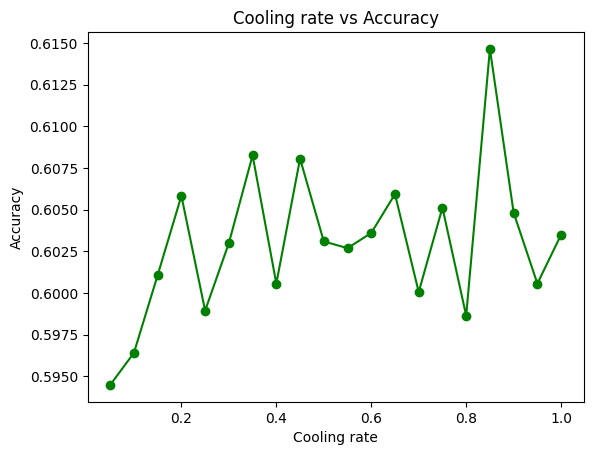

<Figure size 640x480 with 0 Axes>

In [97]:
#Cooling rate vs Accuracy

from matplotlib import pyplot as plot
#%pylab inline#jupyter

cooling_rates = []
i = 0
while i < 1:
    i += 0.05
    cooling_rates.append(i)

results = []

for rate in cooling_rates:
    solutions_sa = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = simulated_annealing(row, N = 10, initial_temperature=1, cooling_rate=rate)
        solutions_sa.append(1 if target == solution else 0)
    results.append(np.mean(solutions_sa))

plot.plot(cooling_rates, results, color='green', marker='o', linestyle='solid')
plot.title("Cooling rate vs Accuracy")
plot.xlabel("Cooling rate")
plot.ylabel("Accuracy")
plot.show()

plot.savefig('CoolingRate_Accuracy.png')

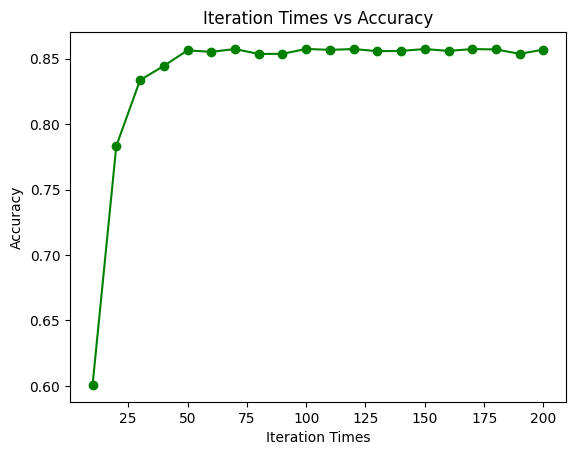

<Figure size 640x480 with 0 Axes>

In [98]:
#Iteration Times vs Accuracy

from matplotlib import pyplot as plot
#%pylab inline#jupyter

N_list = []
i = 1
while i < 21:
    N_list.append(i*10)
    i += 1

results = []

for n in N_list:
    solutions_sa = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = simulated_annealing(row, N = n, initial_temperature=1, cooling_rate=0.95)
        solutions_sa.append(1 if target == solution else 0)
    results.append(np.mean(solutions_sa))

plot.plot(N_list, results, color='green', marker='o', linestyle='solid')
plot.title("Iteration Times vs Accuracy")
plot.xlabel("Iteration Times")
plot.ylabel("Accuracy")
plot.show()

plot.savefig('IterationTimes_Accuracy.png')

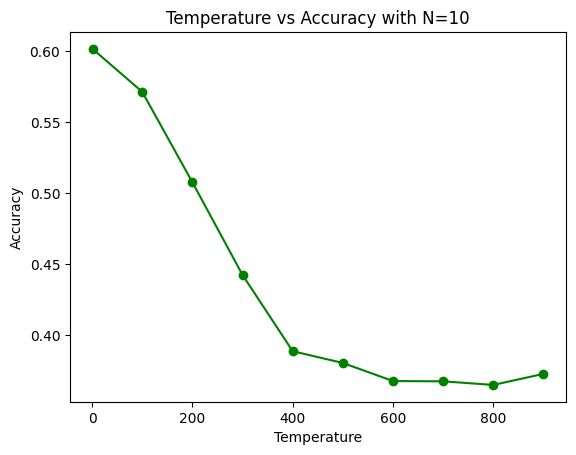

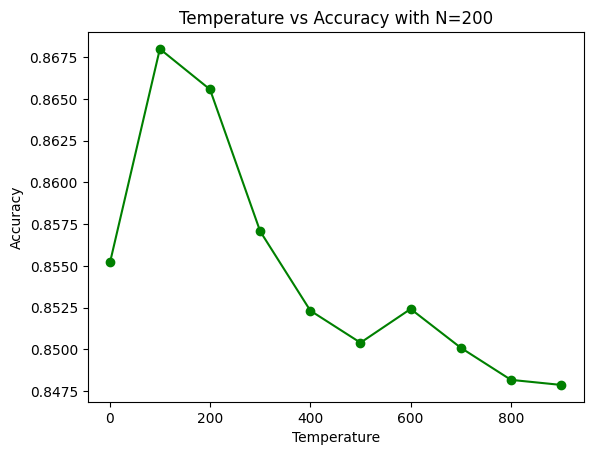

<Figure size 640x480 with 0 Axes>

In [101]:
#Temperature vs Accuracy

from matplotlib import pyplot as plot
#%pylab inline#jupyter

temperatures = []
i = 1
temperatures.append(1)
while i < 10:
    temperatures.append(i*100)
    i += 1

results = []
results2 = []

for temperature in temperatures:
    solutions_sa = []
    solutions_sa2 = []
    for _, row in dataset.iterrows():
        target = row['Best price']
        solution, indexes = simulated_annealing(row, N = 10, initial_temperature=temperature, cooling_rate=0.95)
        solution2, indexes2 = simulated_annealing(row, N = 200, initial_temperature=temperature, cooling_rate=0.95)
        solutions_sa.append(1 if target == solution else 0)
        solutions_sa2.append(1 if target == solution2 else 0)
    results.append(np.mean(solutions_sa))
    results2.append(np.mean(solutions_sa2))

plot.plot(temperatures, results, color='green', marker='o', linestyle='solid')
plot.title("Temperature vs Accuracy with N=10")
plot.xlabel("Temperature")
plot.ylabel("Accuracy")
plot.show()

plot.savefig('Temperature_Accuracy1.png')


plot.plot(temperatures, results2, color='green', marker='o', linestyle='solid')
plot.title("Temperature vs Accuracy with N=200")
plot.xlabel("Temperature")
plot.ylabel("Accuracy")
plot.show()

plot.savefig('Temperature_Accuracy2.png')

------------------------------------------------------------------------------------------------

**7. Genetic Algorithm**

Give a description... Also, make sure that you put comments using your own words in the code to show that you understand the code that you are submitting.

In [ ]:
import random

def calculate_fitness(ind, prices, weights, capacity):
    return fitness

def crossover(parent1, parent2, cross_rate):
    return child1, child2

def mutation(child, mut_rate):
    return child

def genetic_algorithm(data, population_size, num_generations, mut_rate, cross_rate, tournament_size):
    return best_solution_price, best_solution

In [ ]:
solutions_ga = []
for _, row in dataset.iterrows():
    target = row['Best price']
    solution, indexes = genetic_algorithm(row, population_size = 50, num_generations = 50, mut_rate = 0.1, cross_rate = 0.7, tournament_size = 5)
    solutions_ga.append(1 if target == solution else 0)


In [ ]:
print("Genetic Algorithm Accuracy is", np.mean(solutions_ga))

**Your Analysis:**

------------------------------------------------------------------------------------------------

**8. Comparative Study**

description  +  tables/figures

--------------------------------------------------------------------------


**9. Conclusion**

Comment on the empirical study, its results, and give ideas for future work.

--------------------------------------------------------------------------


**10 References**

Make sure you provide references to ALL sources used (articles, code, algorithms).

**Hint:** To share a link to your colab notebook, click on "share" on the top right. Then, under *General access* , change *Restricted* to "Anyone with the link".